In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA


In [5]:
df_client = pd.read_excel("data/clients.xlsx")
df_action = pd.read_excel("data/actions.xlsx")
df_transactions = pd.read_excel("data/transactions.xlsx")

# Prepare data for clustering 

In [6]:
# Merge df_client and df_transactions on `client_id`
df_client_trans = pd.merge(df_client, df_transactions, on="client_id", how="left")

In [7]:
# Mark the clients with no transaction
df_client_trans["has_transaction"] = (
    df_client_trans["transaction_id"].notna().astype(int)
)
df_client_trans.head()

,client_id,client_country,client_gender,client_nationality,client_city,client_premium_status,client_is_phone_contactable,client_is_email_contactable,client_is_instant_messaging_contactable,client_is_contactable,transaction_id,transaction_date,product_quantity,gross_amount_euro,product_category,product_subcategory,product_style,has_transaction
0,c41404743,BN,NaN,NaN,NaN,0,0,0,1,1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,0
1,c65630254,CA,NaN,NaN,NaN,0,0,0,1,1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,0
2,c89796498,NL,NaN,NaN,NaN,0,0,0,1,1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,0
3,c03959902,SE,NaN,NaN,NaN,0,0,0,1,1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,0
4,c39809280,BG,NaN,NaN,NaN,0,0,0,1,1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,0


In [8]:
df_client_summary = df_client_trans.groupby("client_id").agg(
    {
        # Client information: Taking the first occurrence of each (they should be the same for each client)
        "client_country": "first",
        "client_nationality": "first",
        "client_city": "first",
        "client_premium_status": "first",
        "client_is_phone_contactable": "first",
        "client_is_email_contactable": "first",
        "client_is_instant_messaging_contactable": "first",
        "client_is_contactable": "first",
        # Aggregating transactions-related data
        "has_transaction": "sum",  # Number of transactions (since has_transaction = 1 if transaction exists)
        "product_quantity": "sum",  # Total quantity of products purchased
        "gross_amount_euro": "sum",  # Total amount spent
        # Transaction date list (need to list dates of all transactions)
        "transaction_date": lambda x: list(x) if not x.isna().all() else [],
        # Most common product category, subcategory, and style
        "product_category": lambda x: (
            x.mode()[0] if not x.mode().empty else None
        ),  # Most common value
        "product_subcategory": lambda x: x.mode()[0] if not x.mode().empty else None,
        "product_style": lambda x: x.mode()[0] if not x.mode().empty else None,
    }
)

# Renaming columns after aggregation
df_client_summary = df_client_summary.rename(
    columns={
        "client_country": "Country",
        "client_nationality": "Nationality",
        "client_city": "City",
        "client_premium_status": "Premium Status",
        "client_is_phone_contactable": "Is Phone Contactable",
        "client_is_email_contactable": "Is Email Contactable",
        "client_is_instant_messaging_contactable": "Is Message Contactable",
        "client_is_contactable": "Is Contactable",
        "has_transaction": "Transaction Count",
        "product_quantity": "Total Product Quantity",
        "gross_amount_euro": "Total Spending",
        "transaction_date": "Transaction Dates",
        "product_category": "Most Frequent Product Category",
        "product_subcategory": "Most Frequent Product Subcategory",
        "product_style": "Most Frequent Product Style",
    }
)

# Creating additional derived columns
df_client_summary["gross_amount_per_product"] = np.where(
    df_client_summary["Total Product Quantity"] == 0,
    0,
    df_client_summary["Total Spending"] / df_client_summary["Total Product Quantity"],
)

df_client_summary["gross_amount_per_transaction"] = np.where(
    df_client_summary["Transaction Count"] == 0,
    0,
    df_client_summary["Total Spending"] / df_client_summary["Transaction Count"],
)

df_client_summary["products_per_transaction"] = np.where(
    df_client_summary["Transaction Count"] == 0,
    0,
    df_client_summary["Total Product Quantity"]
    / df_client_summary["Transaction Count"],
)

df_client_summary = df_client_summary.fillna("unknown")

# Reset index to make 'client_id' a column again
df_client_summary = df_client_summary.reset_index()

df_client_summary.head()

,client_id,Country,Nationality,City,Premium Status,Is Phone Contactable,Is Email Contactable,Is Message Contactable,Is Contactable,Transaction Count,Total Product Quantity,Total Spending,Transaction Dates,Most Frequent Product Category,Most Frequent Product Subcategory,Most Frequent Product Style,gross_amount_per_product,gross_amount_per_transaction,products_per_transaction
0,c00003572,JP,unknown,unknown,0,0,0,0,0,0,0.0,0.0,[],unknown,unknown,unknown,0.0,0.0,0.0
1,c00007878,unknown,unknown,unknown,0,0,0,0,0,0,0.0,0.0,[],unknown,unknown,unknown,0.0,0.0,0.0
2,c00009439,JP,JPN,unknown,0,0,0,0,0,0,0.0,0.0,[],unknown,unknown,unknown,0.0,0.0,0.0
3,c00015183,US,USA,SAN DIEGO,0,0,1,1,1,0,0.0,0.0,[],unknown,unknown,unknown,0.0,0.0,0.0
4,c00015592,AU,unknown,unknown,0,0,0,0,0,0,0.0,0.0,[],unknown,unknown,unknown,0.0,0.0,0.0


In [9]:
# Count the number of clients that have a duplicate (same profile)
df_without_id = df_client_summary.drop(columns=["client_id", "Transaction Dates"])
duplicate_rows = df_without_id.duplicated(keep=False)
num_duplicates = duplicate_rows.sum()
print(f"Number of rows that are duplicates lines: {num_duplicates}")
print(
    f"So, {num_duplicates/len(df_client_summary)*100}% of duplicates lines in the dataframe."
)

Number of rows that are duplicates lines: 13662
So, 47.5183471879239% of duplicates lines in the dataframe.


In [10]:
# Exclude `client_id` and unhashable columns
df_without_id = df_client_summary.drop(columns=["client_id", "Transaction Dates"])

# Group by all columns and count occurrences
duplicates_with_counts = (
    df_without_id.groupby(df_without_id.columns.tolist())
    .size()
    .reset_index(name="Count")
)

# Filter rows where duplicates occur (Count > 1)
duplicates_only = duplicates_with_counts[duplicates_with_counts["Count"] > 1]

duplicates_only = duplicates_only.sort_values(by="Count", ascending=False)

# Display the duplicates and their counts
print(f"Number of unique duplicate rows: {duplicates_only.shape[0]}")
duplicates_only

Number of unique duplicate rows: 566


,Country,Nationality,City,Premium Status,Is Phone Contactable,Is Email Contactable,Is Message Contactable,Is Contactable,Transaction Count,Total Product Quantity,Total Spending,Most Frequent Product Category,Most Frequent Product Subcategory,Most Frequent Product Style,gross_amount_per_product,gross_amount_per_transaction,products_per_transaction,Count
13164,unknown,unknown,unknown,0,0,0,0,0,0,0.0,0.0,unknown,unknown,unknown,0.0,0.0,0.0,4436
7858,JP,unknown,unknown,0,0,0,0,0,0,0.0,0.0,unknown,unknown,unknown,0.0,0.0,0.0,839
2400,AE,unknown,unknown,0,0,0,1,1,0,0.0,0.0,unknown,unknown,unknown,0.0,0.0,0.0,567
11778,US,unknown,unknown,0,0,0,0,0,0,0.0,0.0,unknown,unknown,unknown,0.0,0.0,0.0,547
5314,FR,unknown,unknown,0,0,0,0,0,0,0.0,0.0,unknown,unknown,unknown,0.0,0.0,0.0,530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,AE,ARE,ABU DABI,0,0,0,1,1,0,0.0,0.0,unknown,unknown,unknown,0.0,0.0,0.0,2
7809,JP,JPN,大阪市,0,0,0,0,0,0,0.0,0.0,unknown,unknown,unknown,0.0,0.0,0.0,2
7801,JP,JPN,仙台市,0,0,0,0,0,0,0.0,0.0,unknown,unknown,unknown,0.0,0.0,0.0,2
7760,IT,unknown,unknown,0,0,1,1,1,0,0.0,0.0,unknown,unknown,unknown,0.0,0.0,0.0,2


In [11]:
# Add some information about the event
number_of_invitation = df_action.groupby("client_id").agg(
    {"client_is_invited": "count", "action_start_date": lambda x: list(x)}
)

number_of_invitation = number_of_invitation.rename(
    columns={
        "client_is_invited": "Number of Invitation",
        "action_start_date": "List of dates event",
    }
)
number_of_invitation = number_of_invitation.reset_index()

df_client_summary = pd.merge(
    df_client_summary, number_of_invitation, on="client_id", how="left"
)

df_client_summary = df_client_summary.fillna(0)
df_client_summary.head()

,client_id,Country,Nationality,City,Premium Status,Is Phone Contactable,Is Email Contactable,Is Message Contactable,Is Contactable,Transaction Count,...,Total Spending,Transaction Dates,Most Frequent Product Category,Most Frequent Product Subcategory,Most Frequent Product Style,gross_amount_per_product,gross_amount_per_transaction,products_per_transaction,Number of Invitation,List of dates event
0,c00003572,JP,unknown,unknown,0,0,0,0,0,0,...,0.0,[],unknown,unknown,unknown,0.0,0.0,0.0,0.0,0
1,c00007878,unknown,unknown,unknown,0,0,0,0,0,0,...,0.0,[],unknown,unknown,unknown,0.0,0.0,0.0,0.0,0
2,c00009439,JP,JPN,unknown,0,0,0,0,0,0,...,0.0,[],unknown,unknown,unknown,0.0,0.0,0.0,0.0,0
3,c00015183,US,USA,SAN DIEGO,0,0,1,1,1,0,...,0.0,[],unknown,unknown,unknown,0.0,0.0,0.0,1.0,[2021-01-29 00:00:00]
4,c00015592,AU,unknown,unknown,0,0,0,0,0,0,...,0.0,[],unknown,unknown,unknown,0.0,0.0,0.0,0.0,0


In [12]:
# Check people that don't have any transaction but are invited
people_without_trans_invited = df_client_summary[
    (df_client_summary["Transaction Count"] == 0)
    & (df_client_summary["Number of Invitation"] != 0)
]
print(people_without_trans_invited["Number of Invitation"].unique())
numerical_columns = [
    "Transaction Count",
    "Total Product Quantity",
    "Total Spending",
    "gross_amount_per_product",
    "gross_amount_per_transaction",
    "products_per_transaction",
]

categorical_columns = [
    "Country",
    "Premium Status",
    "Nationality",
    "City",
    "Most Frequent Product Category",
    "Most Frequent Product Subcategory",
    "Most Frequent Product Style",
]


# Check for None/NaN, 0, or [] across all rows
def check_invalid_rows(row):
    # Check if all numerical columns are 0 or NaN
    numerical_check = all(
        (row[col] == 0 or pd.isna(row[col])) for col in numerical_columns
    )

    # Check if any list-type columns (e.g., 'Transaction Dates') are empty
    list_columns = ["Transaction Dates"]  # Add other list columns as needed
    list_check = all(
        (len(row[col]) == 0 if isinstance(row[col], list) else pd.isna(row[col]))
        for col in list_columns
    )

    # Check if all categorical columns contain 'unknown'
    categorical_check = all(
        (row[col] == "unknown" or pd.isna(row[col])) for col in categorical_columns
    )

    # Check if all values are None, 0, or []
    return numerical_check and list_check and categorical_check


# Apply this check across all rows in the dataframe
invalid_clients = people_without_trans_invited[
    people_without_trans_invited.apply(check_invalid_rows, axis=1)
]

invalid_clients

[1. 2. 3. 9. 4.]


,client_id,Country,Nationality,City,Premium Status,Is Phone Contactable,Is Email Contactable,Is Message Contactable,Is Contactable,Transaction Count,...,Total Spending,Transaction Dates,Most Frequent Product Category,Most Frequent Product Subcategory,Most Frequent Product Style,gross_amount_per_product,gross_amount_per_transaction,products_per_transaction,Number of Invitation,List of dates event


In [13]:
# Remove the event information
df_client_summary.drop(
    columns=["Number of Invitation", "List of dates event"], inplace=True
)

In [14]:
# Drop the client with no information at all
numerical_columns = [
    "Transaction Count",
    "Total Product Quantity",
    "Total Spending",
    "gross_amount_per_product",
    "gross_amount_per_transaction",
    "products_per_transaction",
    "Premium Status",
]

categorical_columns = [
    "Country",
    "Nationality",
    "City",
    "Most Frequent Product Category",
    "Most Frequent Product Subcategory",
    "Most Frequent Product Style",
]


# Check for None/NaN, 0, or [] across all rows
def check_invalid_rows(row):
    # Check if all numerical columns are 0 or NaN
    numerical_check = all(
        (row[col] == 0 or pd.isna(row[col])) for col in numerical_columns
    )

    list_columns = ["Transaction Dates"]
    list_check = all(
        (len(row[col]) == 0 if isinstance(row[col], list) else pd.isna(row[col]))
        for col in list_columns
    )

    # Check if all categorical columns contain 'unknown'
    categorical_check = all(
        (row[col] == "unknown" or pd.isna(row[col])) for col in categorical_columns
    )

    # Check if all values are None, 0, or []
    return numerical_check and list_check and categorical_check


# Identify rows that meet the invalid condition
invalid_rows_mask = df_client_summary.apply(check_invalid_rows, axis=1)

# Remove invalid rows
df_cleaned = df_client_summary[~invalid_rows_mask].reset_index(drop=True)

print(f"Original dataset size: {df_client_summary.shape[0]}")
print(f"Cleaned dataset size: {df_cleaned.shape[0]}")
print(f"Number of removed rows: {df_client_summary.shape[0] - df_cleaned.shape[0]}")

Original dataset size: 28751
Cleaned dataset size: 23961
Number of removed rows: 4790


# Clustering

In [15]:
# Do a first clustering to found 5 categories of clients
df_clustering = df_cleaned.copy()

numerical_cols = [
    "Transaction Count",
    "Total Product Quantity",
    "Total Spending",
    "gross_amount_per_product",
    "gross_amount_per_transaction",
    "products_per_transaction",
]
categorical_cols = [
    "Country",
    "Nationality",
    "City",
    "Most Frequent Product Category",
    "Most Frequent Product Subcategory",
    "Most Frequent Product Style",
]

other_columns = [
    "Is Phone Contactable",
    "Is Email Contactable",
    "Is Message Contactable",
    "Is Contactable",
]

# Preprocessing: One-hot encoding categorical features and scaling numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("passthrough", "passthrough", other_columns),
    ]
)
clustering_data = preprocessor.fit_transform(df_clustering)
if hasattr(clustering_data, "toarray"):  # Convert sparse matrix to dense format
    clustering_data = clustering_data.toarray()


# Perform weighted KMeans clustering
mini_kmeans = AgglomerativeClustering(n_clusters=5)
df_clustering["Category"] = mini_kmeans.fit_predict(clustering_data)

In [16]:
# Perform subcategory clustering within each main categroy
for cluster in df_clustering["Category"].unique():
    cluster_data = df_clustering[df_clustering["Category"] == cluster]

    # Preprocess the cluster-specific data
    cluster_data_transformed = preprocessor.transform(
        cluster_data.drop(columns=["Category"])
    )
    if hasattr(cluster_data_transformed, "toarray"):
        cluster_data_transformed = cluster_data_transformed.toarray()

    # Check if there are enough points to create subcategories
    if cluster_data.shape[0] > 3:  # Only cluster if enough data points exist
        agg_sub = AgglomerativeClustering(n_clusters=3)
        df_clustering.loc[df_clustering["Category"] == cluster, "Sub-Category"] = (
            agg_sub.fit_predict(cluster_data_transformed)
        )
    else:
        df_clustering.loc[df_clustering["Category"] == cluster, "Sub-Category"] = (
            0  # Default subcategory if not enough points
        )

print("Subcategory clustering is complete!")

Subcategory clustering is complete!


## Plot results

<Axes: title={'center': 'Categories Distribution'}, xlabel='Category'>

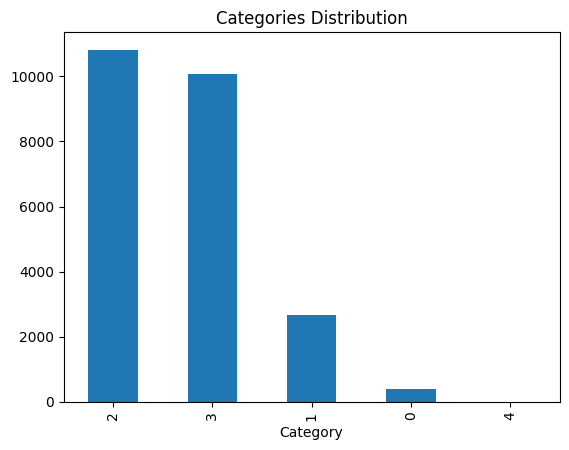

In [17]:
# Plot the distribution of the categories
df_clustering["Category"].value_counts().plot(
    kind="bar", title="Categories Distribution"
)

<Axes: title={'center': 'Category-Subcategory Distribution'}, xlabel='Category,Sub-Category'>

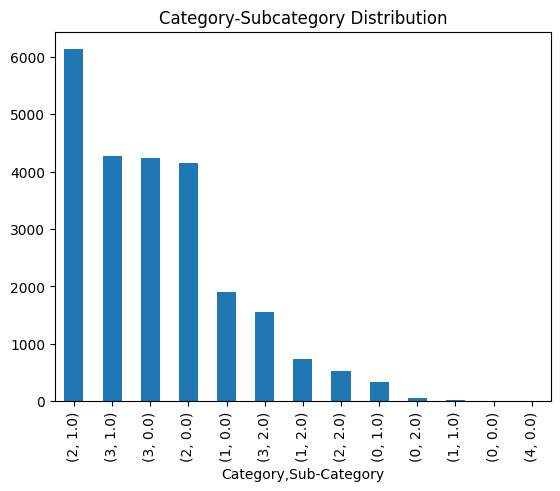

In [18]:
# Count number of clients in each category
df_clustering[["Category", "Sub-Category"]].value_counts().plot(
    kind="bar", title="Category-Subcategory Distribution"
)

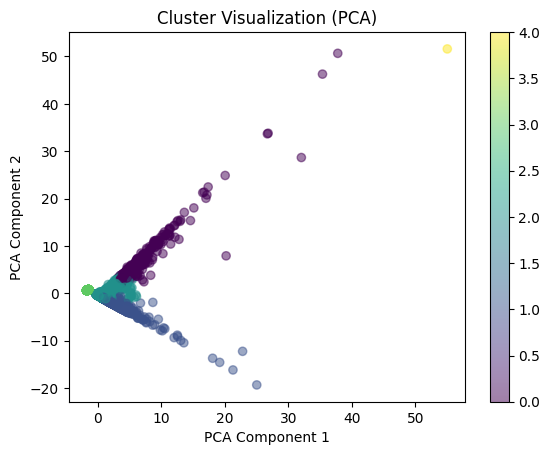

In [19]:
# Visualize Clusters using PCA

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(clustering_data)

# Plot clusters
plt.scatter(
    reduced_features[:, 0],
    reduced_features[:, 1],
    c=df_clustering["Category"],
    cmap="viridis",
    alpha=0.5,
)
plt.title("Cluster Visualization (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar()
plt.show()

# Prepare Data for Prediction Model

In [20]:
# Check if any client appears multiple times for the same event
duplicate_check = df_action.duplicated(
    subset=["client_id", "action_type_label", "action_start_date"], keep=False
)

# Display problematic duplicates
print(f"Number of duplicated client-event rows: {duplicate_check.sum()}")
df_action[duplicate_check].sort_values(by=["client_id", "action_type_label"]).head(10)

Number of duplicated client-event rows: 42


,action_id,action_type_label,action_subcategory_label,action_start_date,action_year,action_end_date,action_collection_year,action_collection,action_universe,action_category_label,action_channel,action_label,client_id,client_is_present,client_is_invited
7308,a804242,Business Treatment,Special Client,2021-03-09,2021,2021-03-09,2021,Winter Collection,Women's Fashion,Client,Outside venue,Business Engagement,c07565705,1,1
7309,a668904,Business Treatment,Special Client,2021-03-09,2021,2021-03-09,2021,Winter Collection,Women's Fashion,Client,Outside venue,Business Engagement,c07565705,1,1
6663,a391984,Collection,Collection,2020-06-24,2020,2020-07-15,2020,Fall Collection,Women's Fashion,Retail,In store,Exclusive Offer,c14195223,0,1
7329,a164455,Collection,Collection,2020-06-24,2020,2020-07-15,2020,Fall Collection,Women's Fashion,Retail,NaN,Exclusive Client Days,c14195223,0,1
7535,a953204,Collection,Collection,2022-02-15,2022,2022-02-15,2022,Summer Collection,Women's Fashion,Retail,In store,Exclusive Offer,c14812611,1,1
7545,a142199,Collection,Collection,2022-02-15,2022,2022-02-15,2022,Summer Collection,Women's Fashion,Retail,In store,Exclusive Offer,c14812611,1,1
7537,a953204,Collection,Collection,2022-02-15,2022,2022-02-15,2022,Summer Collection,Women's Fashion,Retail,In store,Exclusive Offer,c22012237,1,1
7541,a142199,Collection,Collection,2022-02-15,2022,2022-02-15,2022,Summer Collection,Women's Fashion,Retail,In store,Exclusive Offer,c22012237,1,1
4896,a595644,Social Celebrity Action,Collection,2020-01-25,2020,2020-01-26,2020,Retail Action,Men's Fashion,Retail,In store,Miscellaneous Social Gathering,c23767597,1,1
4898,a595644,Social Celebrity Action,Collection,2020-01-25,2020,2020-01-26,2020,Retail Action,Men's Fashion,Retail,In store,Miscellaneous Social Gathering,c23767597,1,1


In [21]:
# Drop the duplicates
df_action_unique = df_action.drop_duplicates(
    subset=["client_id", "action_type_label", "action_start_date"]
)

# Verify row count after deduplication
print(f"Original df_action size: {df_action.shape[0]}")
print(f"After deduplication: {df_action_unique.shape[0]}")

Original df_action size: 10000
After deduplication: 9979


In [22]:
# Ensure event data is unique per event type, not per invite action
df_events_unique = df_action_unique[
    [
        "action_type_label",
        "action_subcategory_label",
        "action_start_date",
        "action_year",
        "action_end_date",
        "action_collection_year",
        "action_collection",
        "action_universe",
        "action_category_label",
        "action_channel",
        "action_label",
    ]
].drop_duplicates()

# Create Cartesian product: every client x every event
df_full_events = df_clustering[["client_id"]].merge(df_events_unique, how="cross")

# Set default values for 'client_is_invited' and 'client_is_present' to 0
df_full_events["client_is_invited"] = 0
df_full_events["client_is_present"] = 0

In [23]:
# Merge with df_action to update invited and present clients
df_full_events = df_full_events.merge(
    df_action_unique[
        [
            "client_id",
            "action_type_label",
            "action_subcategory_label",
            "action_start_date",
            "client_is_invited",
            "client_is_present",
        ]
    ],
    on=[
        "client_id",
        "action_type_label",
        "action_subcategory_label",
        "action_start_date",
    ],
    how="left",
    suffixes=("", "_from_action"),
)

# Resolve conflicts by prioritizing real invitation data
df_full_events["client_is_invited"] = df_full_events[
    "client_is_invited_from_action"
].fillna(df_full_events["client_is_invited"])
df_full_events["client_is_present"] = df_full_events[
    "client_is_present_from_action"
].fillna(df_full_events["client_is_present"])

# Drop the extra columns from df_action merge
df_full_events.drop(
    columns=["client_is_invited_from_action", "client_is_present_from_action"],
    inplace=True,
)

# Ensure missing values are filled with 0 (for clients who were never invited)
df_full_events["client_is_invited"].fillna(0, inplace=True)
df_full_events["client_is_present"].fillna(0, inplace=True)

/var/folders/2r/xjzdhv614ll26kt0l39p1gr00000gn/T/ipykernel_54414/1719399483.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_full_events["client_is_invited"].fillna(0, inplace=True)
/var/folders/2r/xjzdhv614ll26kt0l39p1gr00000gn/T/ipykernel_54414/1719399483.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

In [24]:
# Ensure dates are in datetime format (only if not already)
df_transactions["transaction_date"] = pd.to_datetime(
    df_transactions["transaction_date"]
)
df_full_events["action_start_date"] = pd.to_datetime(
    df_full_events["action_start_date"]
)

# Merge transactions with events based on client_id
df_merged = df_transactions.merge(
    df_full_events[["client_id", "action_start_date"]], on="client_id", how="inner"
)

# Keep only transactions that happened BEFORE the event date
df_merged = df_merged[df_merged["transaction_date"] < df_merged["action_start_date"]]

# Aggregate transaction data
df_transaction_summary = (
    df_merged.groupby(["client_id", "action_start_date"])
    .agg(
        total_transactions=("transaction_id", "count"),
        total_spending=("gross_amount_euro", "sum"),
        total_product_quantity=("product_quantity", "sum"),
        last_transaction_date=("transaction_date", "max"),
        most_frequent_product_category=(
            "product_category",
            lambda x: x.mode()[0] if not x.mode().empty else "unknown",
        ),
        most_frequent_product_subcategory=(
            "product_subcategory",
            lambda x: x.mode()[0] if not x.mode().empty else "unknown",
        ),
        most_frequent_product_style=(
            "product_style",
            lambda x: x.mode()[0] if not x.mode().empty else "unknown",
        ),
    )
    .reset_index()
)


#  Merge back with df_full_events
df_full_events = df_full_events.merge(
    df_transaction_summary, on=["client_id", "action_start_date"], how="left"
)

# Fill missing values for clients with no transactions before the event
df_full_events.fillna(
    {
        "total_transactions": 0,
        "total_spending": 0,
        "total_product_quantity": 0,
        "last_transaction_date": pd.NaT,
        "most_frequent_product_category": "unknown",
        "most_frequent_product_subcategory": "unknown",
        "most_frequent_product_style": "unknown",
    },
    inplace=True,
)


# Add the clients information
df_client_category = df_clustering.drop(
    columns=[
        "Is Contactable",
        "Transaction Count",
        "Total Spending",
        "Total Product Quantity",
        "Transaction Dates",
        "Most Frequent Product Category",
        "Most Frequent Product Subcategory",
        "Most Frequent Product Style",
        "gross_amount_per_product",
        "gross_amount_per_transaction",
        "products_per_transaction",
    ]
)
df_final = df_full_events.merge(df_client_category, on="client_id", how="left")

df_final.head()

,client_id,action_type_label,action_subcategory_label,action_start_date,action_year,action_end_date,action_collection_year,action_collection,action_universe,action_category_label,...,most_frequent_product_style,Country,Nationality,City,Premium Status,Is Phone Contactable,Is Email Contactable,Is Message Contactable,Category,Sub-Category
0,c00003572,Collection,Collection,2022-04-07,2022,2022-04-11,2022,Mid-Season Jewelry and Timepieces,Timepieces and Jewelry,Retail,...,unknown,JP,unknown,unknown,0,0,0,0,3,1.0
1,c00003572,Collection,Collection,2021-10-20,2021,2021-10-21,2021,Sailor Collection,Women's Fashion,Retail,...,unknown,JP,unknown,unknown,0,0,0,0,3,1.0
2,c00003572,Collection,Collection,2020-10-29,2020,2020-10-29,2020,Spring Collection,Men's Fashion,Retail,...,unknown,JP,unknown,unknown,0,0,0,0,3,1.0
3,c00003572,Collection,Collection,2022-01-11,2022,2022-01-11,2022,Formal Retail Action,Men's Fashion,Retail,...,unknown,JP,unknown,unknown,0,0,0,0,3,1.0
4,c00003572,Collection,Collection,2021-05-27,2021,2021-06-21,2021,Mid-Season Jewelry and Timepieces,Timepieces and Jewelry,Retail,...,unknown,JP,unknown,unknown,0,0,0,0,3,1.0


In [25]:
# Define new column order
new_column_order = [
    # Client Information
    "client_id",
    "Country",
    "Nationality",
    "City",
    "Premium Status",
    "Is Phone Contactable",
    "Is Email Contactable",
    "Is Message Contactable",
    "Category",
    "Sub-Category",
    # Transaction History (Before the Event)
    "total_transactions",
    "total_spending",
    "total_product_quantity",
    "last_transaction_date",
    "most_frequent_product_category",
    "most_frequent_product_subcategory",
    "most_frequent_product_style",
    # Event Information
    "action_type_label",
    "action_subcategory_label",
    "action_start_date",
    "action_end_date",
    "action_year",
    "action_collection_year",
    "action_collection",
    "action_universe",
    "action_category_label",
    "action_channel",
    "action_label",
    "client_is_present",
    "client_is_invited",
]

# Rename columns for clarity
column_renaming = {
    # Transaction History
    "total_transactions": "Total Past Transactions",
    "total_spending": "Total Past Spending (€)",
    "total_product_quantity": "Total Past Products Purchased",
    "last_transaction_date": "Last Purchase Date",
    "most_frequent_product_category": "Most Purchased Product Category",
    "most_frequent_product_subcategory": "Most Purchased Product Subcategory",
    "most_frequent_product_style": "Most Purchased Product Style",
}

# Reorder and rename columns
df_final = df_final[new_column_order].rename(columns=column_renaming)


df_final.head()

,client_id,Country,Nationality,City,Premium Status,Is Phone Contactable,Is Email Contactable,Is Message Contactable,Category,Sub-Category,...,action_end_date,action_year,action_collection_year,action_collection,action_universe,action_category_label,action_channel,action_label,client_is_present,client_is_invited
0,c00003572,JP,unknown,unknown,0,0,0,0,3,1.0,...,2022-04-11,2022,2022,Mid-Season Jewelry and Timepieces,Timepieces and Jewelry,Retail,In store,Exclusive Offer,0.0,0.0
1,c00003572,JP,unknown,unknown,0,0,0,0,3,1.0,...,2021-10-21,2021,2021,Sailor Collection,Women's Fashion,Retail,In store,Exclusive Offer,0.0,0.0
2,c00003572,JP,unknown,unknown,0,0,0,0,3,1.0,...,2020-10-29,2020,2020,Spring Collection,Men's Fashion,Retail,In store,Social Gathering,0.0,0.0
3,c00003572,JP,unknown,unknown,0,0,0,0,3,1.0,...,2022-01-11,2022,2022,Formal Retail Action,Men's Fashion,Retail,In store,Social Gathering,0.0,0.0
4,c00003572,JP,unknown,unknown,0,0,0,0,3,1.0,...,2021-06-21,2021,2021,Mid-Season Jewelry and Timepieces,Timepieces and Jewelry,Retail,NaN,Exclusive Offer,0.0,0.0


In [26]:
# Download the final dataframe
df_final.to_csv("event_client.csv", index=False)